In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle

2023-10-25 10:54:53.532237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
import kipoiseq
import os

In [122]:
kipoiseq.transforms.functional.rc_dna(seq)

'GGT'

In [12]:
tss_df = pd.read_csv('../results/tss_positions.csv', index_col=None)

In [52]:
for i, row in tss_df.iterrows():
    if row['Strand'] == '-':
        os.remove(f'../results/enformer_gencode_tss_predictions/{i}.npy')


In [20]:
row

Chromosome                 chr1
start                    139379
gene_name            AL627309.1
gene_id       ENSG00000237683.5
Strand                        -
Name: 3339, dtype: object

In [69]:
saved_res[[446, 447, 448, 449], [5111, 5112]]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4,) (2,) 

In [65]:
saved_res = np.load('../results/enformer_gencode_tss_predictions/3339.npy')

In [70]:
model = custom_model.Enformer(bin_index=[446, 447, 448, 449], track_index=[5111, 5112])

In [78]:
seq = seq_parser.extract_seq_centered('chr1', 5000000, '+', 1, False)

In [76]:
seq = seq_parser.extract_seq_centered('chr1', 5000000, '+', model.seq_length)

In [79]:
seq

'A'

In [49]:
pred

array([[[0.04331244, 0.04986824, 0.03695541, ..., 0.01542558,
         0.06338955, 0.03181199],
        [0.04920314, 0.06056298, 0.04521991, ..., 0.01032751,
         0.03348412, 0.02325992],
        [0.0538066 , 0.06485005, 0.05521107, ..., 0.00540646,
         0.01584147, 0.01263902],
        ...,
        [0.00167733, 0.00104085, 0.0004805 , ..., 0.00028945,
         0.00195588, 0.00152151],
        [0.00167772, 0.00103998, 0.00048017, ..., 0.00028789,
         0.00195151, 0.00151289],
        [0.00167612, 0.00103817, 0.00047922, ..., 0.00028624,
         0.00194697, 0.00150558]]], dtype=float32)

In [29]:
seq_parser = utils.SequenceParser('../data/hg19.fa')

In [41]:
seq = seq_parser.extract_seq_centered('chr1', 5000000, '+', 5, False)

In [42]:
seq

'GACCT'

In [43]:
seq = seq_parser.extract_seq_centered('chr1', 5000000, '-', 5, False)
seq

'AGGTC'

In [11]:
seq = seq_parser.extract_seq_centered('chr1', 5000000, '-', 3, False)
seq

'GGT'

In [105]:
gencode_annotations = pr.read_gtf(f'../data/gencode.v43lift37.basic.annotation.gtf')


In [108]:
df = gencode_annotations.df

In [111]:
df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,havana_transcript,exon_number,exon_id,remap_original_location,protein_id,gene_status,remap_substituted_missing_target,transcript_status,ccdsid,artif_dupl
0,chr1,HAVANA,gene,12009,13670,.,+,.,ENSG00000223972.6_6,transcribed_unprocessed_pseudogene,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,12009,13670,.,+,.,ENSG00000223972.6_6,transcribed_unprocessed_pseudogene,...,OTTHUMT00000002844.2_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,12009,12057,.,+,.,ENSG00000223972.6_6,transcribed_unprocessed_pseudogene,...,OTTHUMT00000002844.2_2,1,ENSE00001948541.1_1,chr1:+:12010-12057,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,HAVANA,exon,12178,12227,.,+,.,ENSG00000223972.6_6,transcribed_unprocessed_pseudogene,...,OTTHUMT00000002844.2_2,2,ENSE00001671638.2_1,chr1:+:12179-12227,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,HAVANA,exon,12612,12697,.,+,.,ENSG00000223972.6_6,transcribed_unprocessed_pseudogene,...,OTTHUMT00000002844.2_2,3,ENSE00001758273.2_1,chr1:+:12613-12697,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001895,chrY,HAVANA,exon,59360500,59360548,.,-,.,ENSG00000227159.8_5_PAR_Y,unprocessed_pseudogene,...,OTTHUMT00000058841.1_4,1,ENSE00002072208.1_1,chrY:-:57214350-57214397,NaN,NaN,NaN,NaN,NaN,NaN
2001896,chrY,HAVANA,exon,59360030,59360115,.,-,.,ENSG00000227159.8_5_PAR_Y,unprocessed_pseudogene,...,OTTHUMT00000058841.1_4,2,ENSE00002046926.1_1,chrY:-:57213880-57213964,NaN,NaN,NaN,NaN,NaN,NaN
2001897,chrY,HAVANA,exon,59359676,59359753,.,-,.,ENSG00000227159.8_5_PAR_Y,unprocessed_pseudogene,...,OTTHUMT00000058841.1_4,3,ENSE00002021169.1_1,chrY:-:57213526-57213602,NaN,NaN,NaN,NaN,NaN,NaN
2001898,chrY,HAVANA,exon,59359354,59359508,.,-,.,ENSG00000227159.8_5_PAR_Y,unprocessed_pseudogene,...,OTTHUMT00000058841.1_4,4,ENSE00002036959.1_1,chrY:-:57213204-57213357,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
df[df['gene_type']=='protein_coding']

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,havana_transcript,exon_number,exon_id,remap_original_location,protein_id,gene_status,remap_substituted_missing_target,transcript_status,ccdsid,artif_dupl
27,chr1,HAVANA,gene,65418,71585,.,+,.,ENSG00000186092.7_8,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,chr1,HAVANA,transcript,65418,71585,.,+,.,ENSG00000186092.7_8,protein_coding,...,OTTHUMT00000003223.4_4,NaN,NaN,NaN,ENSP00000493376.2,NaN,NaN,NaN,NaN,NaN
29,chr1,HAVANA,exon,65418,65433,.,+,.,ENSG00000186092.7_8,protein_coding,...,OTTHUMT00000003223.4_4,1,ENSE00003812156.1_1,chr1:+:65419-65433,ENSP00000493376.2,NaN,NaN,NaN,NaN,NaN
30,chr1,HAVANA,UTR,65418,65433,.,+,.,ENSG00000186092.7_8,protein_coding,...,OTTHUMT00000003223.4_4,1,ENSE00003812156.1,chr1:+:65419-65433,ENSP00000493376.2,NaN,NaN,NaN,NaN,NaN
31,chr1,HAVANA,exon,65519,65573,.,+,.,ENSG00000186092.7_8,protein_coding,...,OTTHUMT00000003223.4_4,2,ENSE00003813641.1_1,chr1:+:65520-65573,ENSP00000493376.2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001712,chrY,ENSEMBL,CDS,27184955,27185061,.,-,2,ENSG00000185894.8_10,protein_coding,...,NaN,3,ENSE00003547967.1,chrY:-:25038809-25038914,ENSP00000480751.1,NaN,NaN,NaN,CCDS44030.1,NaN
2001713,chrY,ENSEMBL,exon,27184244,27184263,.,-,.,ENSG00000185894.8_10,protein_coding,...,NaN,4,ENSE00003753422.1_1,chrY:-:25038098-25038116,ENSP00000480751.1,NaN,NaN,NaN,CCDS44030.1,NaN
2001714,chrY,ENSEMBL,CDS,27184247,27184263,.,-,1,ENSG00000185894.8_10,protein_coding,...,NaN,4,ENSE00003753422.1,chrY:-:25038101-25038116,ENSP00000480751.1,NaN,NaN,NaN,CCDS44030.1,NaN
2001715,chrY,ENSEMBL,UTR,27184244,27184247,.,-,.,ENSG00000185894.8_10,protein_coding,...,NaN,4,ENSE00003753422.1,chrY:-:25038098-25038100,ENSP00000480751.1,NaN,NaN,NaN,CCDS44030.1,NaN


In [48]:
target_df = pd.read_csv('../data/enformer_targets_human.txt', sep='\t')

In [49]:
target_df.iloc[5110]

index                                                       5110
genome                                                         0
identifier                                             CNhs12333
file           /home/drk/tillage/datasets/human/cage/fantom/C...
clip                                                         384
scale                                                          1
sum_stat                                                     sum
description    CAGE:B lymphoblastoid cell line: GM12878 ENCOD...
Name: 5110, dtype: object

In [88]:
selected_tss = pd.read_csv('../results/enformer_PC-3_selected_tss.csv')
selected_tss.head(2)

,Unnamed: 0,Chromosome,start,gene_name,gene_id,Strand,PC-3
0,5626,chr1,167905278,MPC2,ENSG00000143158.11_8,-,74.856834
1,30657,chr9,140009185,DPP7,ENSG00000176978.15_9,-,74.879250


In [82]:
tss_df = pd.concat(pd.read_csv(f, index_col='Unnamed: 0') for f in glob.glob(f'../results/enformer*selected_tss.csv'))


In [91]:
cell_lines = [4824, 5110, 5111]
model_name = 'enformer'
targets = pd.read_csv(f'../data/{model_name}_targets_human.txt', sep='\t')
column_names = [t.split(':')[-1].split(' ENCODE')[0].strip() for t in targets.iloc[cell_lines]['description'].values]

In [71]:
row = tss_df.loc[int(ri)].iloc[0]
f"{row['gene_name']}_{row['Chromosome']}_{row['start']}"

'P3H1_chr1_43232683'

In [92]:
column_names

['PC-3', 'GM12878', 'K562']

In [89]:
k562_res = []
for _, row in selected_tss.iterrows():
    
    r = f'../results/context_dependence_test/enformer/{utils.get_summary(row)}.pickle'
    with open(r, 'rb') as handle:
        context_res = pickle.load(handle)
    delta = creme.context_effect_on_tss(context_res['wt'][:,0], context_res['mut'][:,0], 448)
    k562_res.append(delta)

<Axes: ylabel='Count'>

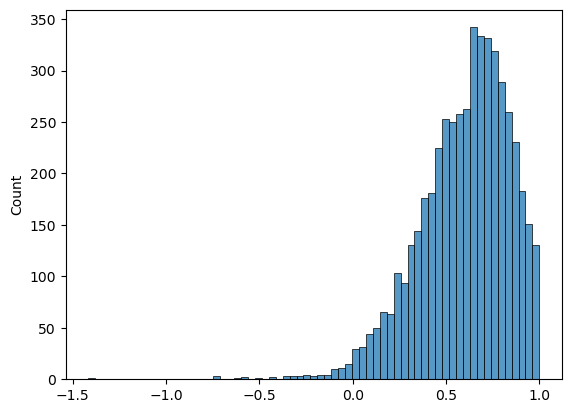

In [90]:
sns.histplot(k562_res)

In [36]:
np.argwhere(np.array(k562_res) < -1000)

array([[ 778],
       [3259],
       [4445],
       [5116],
       [6772]])

In [38]:


with open(result_files[778], 'rb') as handle:
        context_res = pickle.load(handle)

In [42]:
context_res['wt'][448, -1]

0.0004387751

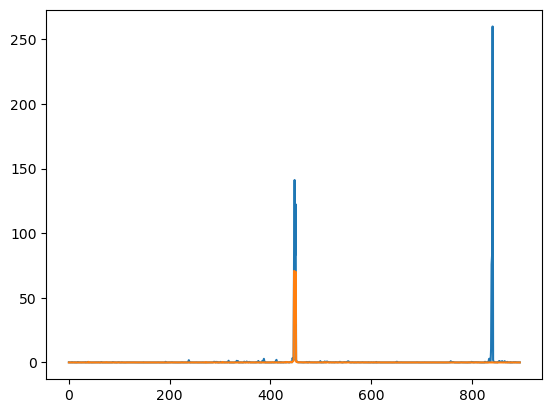

In [27]:
plt.plot(context_res['wt'][:,-1])
plt.plot(context_res['mut'][:,-1])


In [13]:
b

{'wt': array([[0.18113065, 0.24943592, 0.16318935],
        [0.61712396, 2.7481961 , 1.0660298 ],
        [0.30904564, 1.2010484 , 0.53722596],
        ...,
        [1.1740596 , 3.1269925 , 1.2725819 ],
        [0.84712803, 2.5594754 , 0.97441757],
        [0.23775606, 0.37786275, 0.19247302]], dtype=float32),
 'mut': array([[0.01848033, 0.08879419, 0.04317456],
        [0.01576097, 0.05670903, 0.03213033],
        [0.01485418, 0.04590509, 0.02766026],
        ...,
        [0.03157992, 0.15974621, 0.07226846],
        [0.02144169, 0.06145202, 0.03443139],
        [0.02046442, 0.06050266, 0.03276479]], dtype=float32),
 'std': array([[0.00921986, 0.10280044, 0.03671624],
        [0.00491492, 0.03050948, 0.01345512],
        [0.00322134, 0.01455636, 0.00730885],
        ...,
        [0.01238765, 0.12362851, 0.04108834],
        [0.00811556, 0.02107967, 0.01095608],
        [0.00756581, 0.01979333, 0.00728442]], dtype=float32)}